In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'differential_apa_abundance_c2c12',
        root = '..',
    )

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from lapa.result import LapaResult

In [3]:
samples = ['PB154', 'PB155', 'PB213', 'PB214']

In [4]:
df_abundance = pd.read_csv(snakemake.input['abundance'], sep='\t')

In [5]:
df_count = df_abundance.rename(columns={'annot_gene_id': 'gene_id'}).groupby('gene_id')[samples].agg('sum')

In [6]:
df_count['dif'] = df_count[['PB213', 'PB214']].sum(axis=1)
df_count['undif'] = df_count[['PB154', 'PB155']].sum(axis=1)
df_count['log(FC)'] = np.log(df_count['dif'] / df_count['undif'])
df_count['total'] = df_count['dif'] + df_count['undif']

/pub/mcelik/anaconda/envs/lapa/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
df_count

,PB154,PB155,PB213,PB214,dif,undif,log(FC),total
gene_id,,,,,,,,
ENSMUSG00000000001.4,1475,1327,212,218,430,2802,-1.874304,3232
ENSMUSG00000000028.15,488,441,16,17,33,929,-3.337601,962
ENSMUSG00000000031.16,5,7,3403,3575,6978,12,6.365611,6990
ENSMUSG00000000037.16,1,0,1,0,1,1,0.000000,2
ENSMUSG00000000049.11,1,0,2,0,2,1,0.693147,3
...,...,...,...,...,...,...,...,...
gSpikein_ERCC-00160,0,0,1,3,4,0,inf,4
gSpikein_ERCC-00162,0,0,2,0,2,0,inf,2
gSpikein_ERCC-00163,0,0,1,0,1,0,inf,1


In [8]:
result = LapaResult(snakemake.input['long_read'])
df = result.fisher_exact_test({'dif': ['PB213', 'PB214'], 'undif': ['PB154', 'PB155']}, min_gene_count=50)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9397/9397 [00:41<00:00, 224.30it/s]


In [9]:
chrom, pos, strand = zip(*df.reset_index().rename(columns={'index': 'polya_site'})['polya_site'].str.split(':'))
df['Chromosome'] = chrom
df['Start'] = pos
df['Start'] = df['Start'].astype(int)
df['End'] = df['Start'] + 1
df['Strand'] = strand

In [10]:
df = df[(df['delta_usage'].abs() > 0.3) & (df['pval_adj'] < 0.05)]

In [11]:
df.loc[df[df['Strand'] == '+'].groupby('gene_id')['End'].idxmax(), 'distal'] = True
df.loc[df[df['Strand'] == '-'].groupby('gene_id')['Start'].idxmin(), 'distal'] = True
df['distal'] = ~df['distal'].isna()

In [12]:
df['distal'].sum(), df.shape[0]

(725, 1042)

In [13]:
df = df.set_index('gene_id').join(df_count)

In [14]:
df

,odds_ratio,pval,delta_usage,pval_adj,Chromosome,Start,End,Strand,distal,PB154,PB155,PB213,PB214,dif,undif,log(FC),total
gene_id,,,,,,,,,,,,,,,,,
ENSMUSG00000000223.13,0.113326,4.367942e-11,-0.485895,4.707059e-10,chrX,134453400,134453401,+,False,86.0,67.0,47.0,39.0,86.0,153.0,-0.576091,239.0
ENSMUSG00000000223.13,7.659674,5.926547e-08,0.352942,4.444673e-07,chrX,134456572,134456573,+,True,86.0,67.0,47.0,39.0,86.0,153.0,-0.576091,239.0
ENSMUSG00000000253.13,0.000000,1.368906e-18,-0.410000,2.766368e-17,chr13,45546381,45546382,+,True,60.0,84.0,301.0,395.0,696.0,144.0,1.575536,840.0
ENSMUSG00000000567.5,0.162963,2.677815e-11,-0.348138,2.977920e-10,chr11,112785555,112785556,+,True,92.0,89.0,87.0,104.0,191.0,181.0,0.053776,372.0
ENSMUSG00000000581.8,13.704082,3.913042e-13,0.309134,5.171710e-12,chr11,17267230,17267231,+,False,80.0,115.0,120.0,123.0,243.0,195.0,0.220062,438.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000106106.3,6.871250,7.453155e-18,0.384641,1.426422e-16,chr17,39846959,39846960,+,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000106106.3,0.193210,9.798683e-18,-0.389736,1.848960e-16,chr17,39847166,39847167,+,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000111080.1,49.600000,4.170962e-12,0.749121,5.018506e-11,chr10,30603202,30603203,-,True,2.0,0.0,36.0,35.0,71.0,2.0,3.569533,73.0


In [15]:
_df = df[df['distal']]

In [16]:
_df["3' UTR length"] = np.where(_df['delta_usage'] > 0, 'elongation', 'shortening')

/tmp/ipykernel_68749/3812211350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df["3' UTR length"] = np.where(_df['delta_usage'] > 0, 'elongation', 'shortening')


In [17]:
_df["3' UTR length"].unique()

array(['elongation', 'shortening'], dtype=object)

In [18]:
_df = _df[~_df['log(FC)'].isna()].sort_values("3' UTR length", ascending=False)

In [19]:
mannwhitneyu(
    _df[_df["3' UTR length"] == 'elongation']['log(FC)'],
    _df[_df["3' UTR length"] == 'shortening']['log(FC)']
)

MannwhitneyuResult(statistic=36744.0, pvalue=2.343547502148926e-19)

shortening vs. elongation: Mann-Whitney-Wilcoxon test two-sided, P_val:2.344e-19 U_stat=8.457e+04


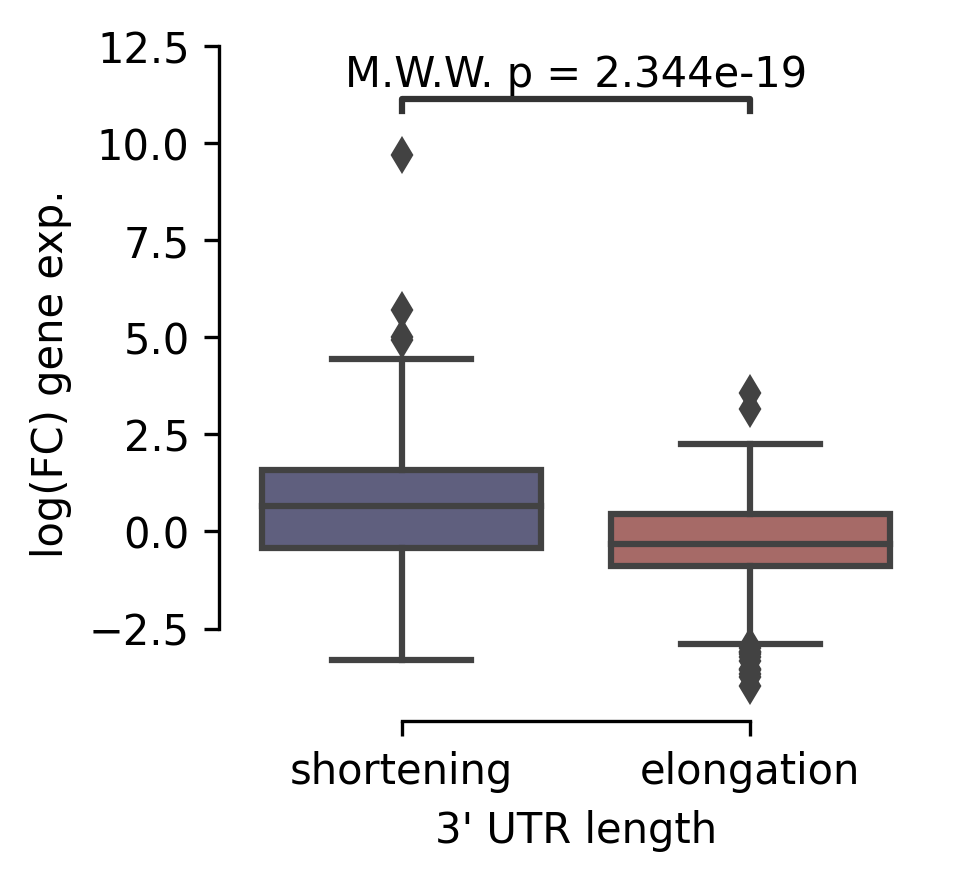

In [20]:
plt.figure(figsize=(3, 3), dpi=300)

ax = sns.boxplot(data=_df, x="3' UTR length", y='log(FC)', palette =['#5a5a83', '#b1615c'])

plt.ylabel('log(FC) gene exp.')

from statannotations.Annotator import Annotator

annot = Annotator(ax, plot='boxplot', pairs=[('elongation', 'shortening')], 
                  data=_df, x="3' UTR length", y='log(FC)')
annot.configure(test='Mann-Whitney', text_format='full').apply_test().annotate()

sns.despine(offset=2, trim=True)

plt.savefig(snakemake.output['boxplot'], dpi=300, bbox_inches='tight', transparent=True)